<a href="https://colab.research.google.com/github/eloimoliner/audio-inpainting-diffusion/blob/main/notebooks/demo_inpainting_spectrogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion-Based Audio Inpainting

This notebook is a demo of the gramophone noise synthesis method proposed in:

> E. Moliner, J. Lehtinen and V. Välimäki,, "Solving audio inverse problems with a diffusion model", submitted to IEEE International Conference on Acoustics, Speech, and Signal Processing (ICASSP) 2023
Rhodes, Greece, May, 2023

Listen to our [audio samples](http://research.spa.aalto.fi/publications/papers/icassp23-cqt-diff/)

### Instructions for running:

* Make sure to use a GPU runtime, click:  __Runtime >> Change Runtime Type >> GPU__
* Press ▶️ on the left of each of the cells
* View the code: Double-click any of the cells
* Hide the code: Double click the right side of the cell


In [1]:
model = 'musicnet' #@param ["maestro", "musicnet"]

In [2]:
%cd /content/
!git clone https://github.com/eloimoliner/audio-inpainting-diffusion.git
%cd audio-inpainting-diffusion
!mkdir experiments

if model=="maestro":
  !mkdir experiments/cqtdiff+_MAESTRO
  !wget -P experiments/cqtdiff+_MAESTRO https://huggingface.co/Eloimoliner/audio-inpainting-diffusion/resolve/main/maestro_22k_8s-750000.pt
elif model=="musicnet":
  !mkdir experiments/cqtdiff+_MUSICNET
  !wget -P experiments/cqtdiff+_MUSICNET https://huggingface.co/Eloimoliner/audio-inpainting-diffusion/resolve/main/musicnet_44k_4s-560000.pt
#!wget https://github.com/eloimoliner/CQTdiff/releases/download/weights_and_examples/examples.zip
#!unzip examples.zip 
!pip install hydra-core
!pip install cqt_nsgt_pytorch
!pip install einops
!pip install wandb
!pip install wget

/content
Cloning into 'audio-inpainting-diffusion'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 116 (delta 50), reused 94 (delta 32), pack-reused 0
Receiving objects: 100% (116/116), 5.18 MiB | 1.92 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/audio-inpainting-diffusion
--2023-01-05 22:36:37--  https://huggingface.co/Eloimoliner/audio-inpainting-diffusion/resolve/main/musicnet_44k_4s-560000.pt
Resolving huggingface.co (huggingface.co)... 18.235.116.140, 54.144.222.129, 2600:1f18:147f:e800:8e23:1296:56ee:cadc, ...
Connecting to huggingface.co (huggingface.co)|18.235.116.140|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/5f/d3/5fd3fb7ca58c57d8e7ebaf90800679406567dd2ea36e6caad04ae7e4f6eea94d/6ae154a9bd685f5d619b8c3027050396d0f722fe6e12d4b3e313a794608b6d76?response-content-disposition=attachment%3B%2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for cqt_nsgt_pytorch: filename=cqt_nsgt_pytorch-0.0.8-py3-none-any.whl size=12418 sha256=4d0067815a84be57cbf23ce609e6902efde79781543d82c64b56f4ea92e04387
  Stored in directory: /root/.cache/pip/wheels/f2/58/14/94140baf45201cbf28718fc4e0e5a97d58ed31405801e7ef79
Successfully built cqt_nsgt_pytorch
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 2.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.3/174.3 KB 17.7 MB/s

In [4]:
#@title #Setup environment
!mkdir notebooks



import hydra
with hydra.initialize(config_path="conf"):
    if model=="maestro":
        ckpt="/content/audio-inpainting-diffusion/experiments/cqtdiff+_MAESTRO/maestro_22k_8s-750000.pt"

        args = hydra.compose(config_name="conf.yaml", overrides=["exp=maestro22k_8s","network=paper_1912_unet_cqt_oct_attention_adaLN_2","tester.checkpoint={ckpt}".format(ckpt=ckpt)], return_hydra_config=True)
    elif model=="musicnet":
        ckpt="/content/audio-inpainting-diffusion/experiments/cqtdiff+_MUSICNET/musicnet_44k_4s-560000.pt"
        args = hydra.compose(config_name="conf.yaml", overrides=["exp=musicnet44k_4s","network=paper_1912_unet_cqt_oct_attention_44k_2","tester.checkpoint={ckpt}".format(ckpt=ckpt)], return_hydra_config=True)
import os
import re
import json
#import click
import torch
import utils.dnnlib as dnnlib
from utils.torch_utils import distributed as dist
import utils.setup as setup

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
#assert torch.cuda.is_available()
#device="cuda"


dirname = os.getcwd()
args.model_dir = os.path.join(dirname, "notebooks")
print(args.model_dir)
if not os.path.exists(args.model_dir):
    raise Exception(f"Model directory {args.model_dir} does not exist")
    #os.makedirs(args.model_dir)

args.exp.model_dir=args.model_dir

diff_params=setup.setup_diff_parameters(args)
network=setup.setup_network(args, device)
#tester=setup.setup_tester(args, network, diff_params, device) #this will be used for making demos during training

#test_set=setup.setup_dataset_test(args)


tester=setup.setup_tester(args, network=network, diff_params=diff_params, test_set=None, device=device) #this will be used for making demos during training
# Print options.
dist.print0()
dist.print0('Training options:')
dist.print0()
dist.print0(f'Output directory:        {args.model_dir}')
dist.print0(f'Network architecture:    {args.network.callable}')
dist.print0(f'Diffusion parameterization:  {args.diff_params.callable}')
dist.print0(f'Tester:                  {args.tester.callable}')
dist.print0(f'Experiment:                  {args.exp.exp_name}')
dist.print0()

# Train.
print("loading checkpoint path:", args.tester.checkpoint)

ckpt=args.tester.checkpoint
state_dict = torch.load(ckpt, map_location="cpu")
print("dds")

tester.it=state_dict['it']

tester.network.load_state_dict(state_dict['ema'])

import base64, os
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
import matplotlib.pyplot as plt
import numpy as np
import wget
from shutil import copyfile
import shutil



canvas_html = """
<style>
.button {
  background-color: #4CAF50;
  border: none;
  color: white;
  padding: 15px 32px;
  text-align: center;
  text-decoration: none;
  display: inline-block;
  font-size: 16px;
  margin: 4px 2px;
  cursor: pointer;
}
</style>
<canvas1 width=%d height=%d>
</canvas1>
<canvas width=%d height=%d>
</canvas>

<button class="button">Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')

var canvas1 = document.querySelector('canvas1')
var ctx1 = canvas.getContext('2d')


ctx.strokeStyle = 'red';

var img = new Image();
img.src = "data:image/%s;charset=utf-8;base64,%s";
console.log(img)
img.onload = function() {
  ctx1.drawImage(img, 0, 0);
};
img.crossOrigin = 'Anonymous';

ctx.clearRect(0, 0, canvas.width, canvas.height);

ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(imgm, filename='drawing.png', w=400, h=200, line_width=1):
  display(HTML(canvas_html % (w, h, w,h, filename.split('.')[-1], imgm, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)


mkdir: cannot create directory ‘notebooks’: File exists
/content/audio-inpainting-diffusion/notebooks
using a kaiser window with beta= 1


<ipython-input-4-bd5bd7b4733f>:7: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize(config_path="conf"):
/usr/local/lib/python3.8/dist-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'conf.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


Attention layer at (down) octave 5
Attention layer at (down) octave 6
Attention layer at (down) octave 7
Attention layer at (up) oct layer 7
Attention layer at (up) oct layer 6
Attention layer at (up) oct layer 5
test_set None

Training options:

Output directory:        /content/audio-inpainting-diffusion/notebooks
Network architecture:    networks.unet_cqt_oct_with_projattention_adaLN_2.Unet_CQT_oct_with_attention
Diffusion parameterization:  diff_params.edm.EDM
Tester:                  testing.tester_inpainting.Tester
Experiment:                  44k_4s

loading checkpoint path: /content/audio-inpainting-diffusion/experiments/cqtdiff+_MUSICNET/musicnet_44k_4s-560000.pt
dds


In [46]:
#@title Select audio example
import glob
import numpy as np
import cv2

example = 0 #@param {type:"slider", min:0, max:9, step:1}
files=glob.glob(os.path.join("data_dir_2","*.wav"))
audio_file=files[example]


import soundfile as sf

segnp, fs =sf.read(audio_file)
print(segnp.shape)
if model=="maestro":  
  assert fs==22050
elif model=="musicnet":
  assert fs==44100

n=os.path.basename(audio_file)
n=os.path.splitext(n)[0]

#crop to 8 seconds
segnp=segnp[:args.exp.audio_len]

seg=torch.Tensor(segnp).unsqueeze(0)
from IPython.display import Audio 
Audio(data=segnp, rate=fs) 

X= tester.get_spectrogram_image(seg)
X=np.clip(X+60,0,60)/60
X=(1-X)*255
X=np.flipud(X).astype(np.uint8)


X=cv2.applyColorMap(X, cv2.COLORMAP_JET)
X = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
#save X as a png image
name="spectrogram.png"
cv2.imwrite(name, X)
input=seg.cpu().numpy() 
from IPython.display import Audio

Audio(input, rate=fs)

(12397369,)


In [47]:
tester.sampler.xi=0.35
tester.sampler.nb_steps=100
tester.sampler.order=2

Will use spectrogram.png for inpainting


torch.Size([1, 184320]) torch.Size([1, 184184])
torch.Size([1, 184184]) torch.Size([1, 184184])


100%|██████████| 100/100 [00:50<00:00,  1.96it/s]


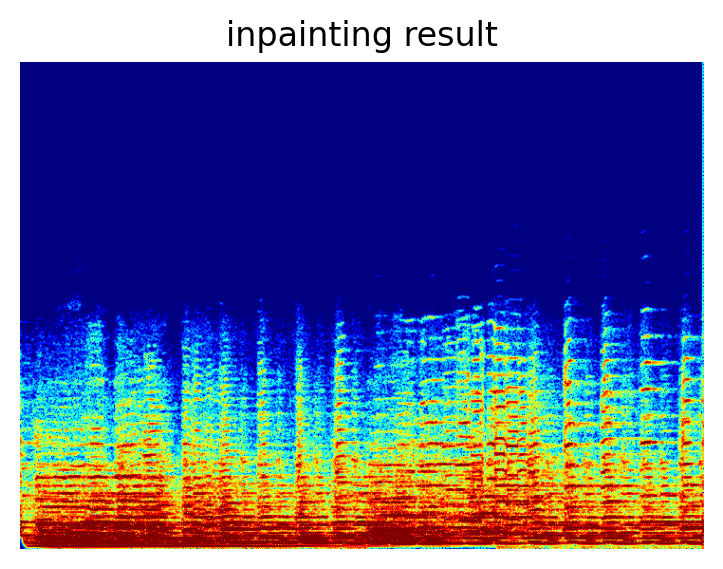

In [49]:
#@title Draw a Mask, Press Finish, Wait for Inpainting

fname=name

image64 = base64.b64encode(open(fname, 'rb').read())
image64 = image64.decode('utf-8')

print(f'Will use {fname} for inpainting')
img = np.array(plt.imread(f'{fname}')[:,:,:3])

draw(image64, filename=f"./{fname.split('.')[1]}_mask.png", w=img.shape[1], h=img.shape[0], line_width=0.04*img.shape[1])
#@title Show a masked image and save a mask
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['figure.dpi'] = 200
plt.subplot(131)
with_mask = np.array(plt.imread(f"./{fname.split('.')[1]}_mask.png")[:,:,:3])
mask = (with_mask[:,:,0]==1)*(with_mask[:,:,1]==0)*(with_mask[:,:,2]==0)

mask=1-torch.flipud(torch.Tensor(mask))
pred=tester.interactive_spectrogram_inpainting(seg, torch.Tensor([fs]), mask)
X= tester.get_spectrogram_image(pred)
X=np.clip(X+60,0,60)/60
X=(1-X)*255
X=np.flipud(X).astype(np.uint8)
import cv2
import numpy as np
X=cv2.applyColorMap(X, cv2.COLORMAP_JET)
X = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
#save X as a png image
namepred="pred.png"
cv2.imwrite(namepred, X)

plt.rcParams['figure.dpi'] = 200
plt.imshow(plt.imread(namepred))
_=plt.axis('off')
_=plt.title('inpainting result')
plt.show()
fname = None

Audio(pred.cpu().numpy(), rate=fs)

In [50]:
!nvidia-smi

Thu Jan  5 22:59:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    50W / 400W |  16518MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------